# **Importing necessary libraries and modules**

In [79]:
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)


**Connecting to the drive to acces the data**

In [80]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Loading the data
The data was preprocessed and stored on the drive for easier accesibility


*   preprocessed_train_data is the data collected for the iperf ran for the duration of 10,20,30,40 Seconds
*   preprocessed_val_data is the data collected for the iperf ran for the duration of 50 Seconds.
*   preprocessed_test_data is the data collected for the iperf ran for the duration of 60 Seconds.
*   preprocessed_train_val_data is a combination of both train and validation sets

In [81]:
DATAPATH = '/content/gdrive/My Drive/Data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
print(train_all_dataset.shape)
print(test_dataset.shape)

(1584, 6)
(392, 6)
(1976, 6)
(391, 6)


## Extracting and normalising the features

The files I have read in are pandas dataframes, containing a wide range of possibly useful features. Now I will perform these steps

1. Extract the features I'll want to use.
2. Train and apply a scaler to the feature matrices.

Starting with extracting the features.

In [82]:
# All possible features
train_dataset.columns

Index(['Bandwidth (Mbits/sec)', 'Duration', 'Duration_of_measurement',
       'Interval_stage', 'Tranfered Trafic (KBytes)', 'Direction_Coded'],
      dtype='object')

In [83]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transfered Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth (Mbits/sec)', 'Duration', 'Tranfered Trafic (KBytes)']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(feature_matrix(train_dataset,features),dtype=np.float32)
train_labels = np.asarray(train_dataset['Tranfered Trafic (KBytes)'],dtype=np.float32)

val_values = np.asarray(feature_matrix(val_dataset,features),dtype=np.float32)
val_labels = np.asarray(val_dataset['Tranfered Trafic (KBytes)'],dtype=np.float32)

# data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_all_dataset,features),dtype=np.float32)
train_all_labels = np.asarray(train_all_dataset['Tranfered Trafic (KBytes)'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(test_dataset,features),dtype=np.float32)
test_labels = np.asarray(test_dataset['Tranfered Trafic (KBytes)'],dtype=np.float32)



# checking
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)



(1584, 3)
(1584,)
(392, 3)
(392,)
(1976, 3)
(1976,)
(391, 3)
(391,)


In [84]:
from sklearn.preprocessing import StandardScaler
SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# Training and applying scaler for test features

SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

In [85]:
# window-based and recurrent networks:
# making predictions seconds ahead. NB: 16 = 8seconds ....

def create_dataset_windowed(features, labels, ahead=16, window_size=1, max_window_size=1):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]



## Simplest sandbox model

The simplest sandbox model I designed just uses the current Transfered traffic to predict the transfered traffic of 4 seconds ahead. In the code below, I create these predictions, and evaluate them, using a 'Plotresults' function.

I extract the labels and the predictions using the functions defined above. I as well apply np.squeeze function for removing unnecessary dimensions from the arrays.
https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html


The results obtained show a pretty close match between all scores.

In [86]:
# I apply current Transfered traffic as prediction
# Since I do not need Tensorflow for this, I will simply use the corresponding loss function from sklearn

from sklearn.metrics import mean_absolute_error

# NOTE: since there is no model involved, no scaler is used here.

train_throughput = np.asarray(feature_matrix(train_dataset,['Tranfered Trafic (KBytes)',]),dtype=np.float32)
val_throughput = np.asarray(feature_matrix(val_dataset,['Tranfered Trafic (KBytes)',]),dtype=np.float32)

train_all_throughput = np.asarray(feature_matrix(train_all_dataset,['Tranfered Trafic (KBytes)',]),dtype=np.float32)
test_throughput = np.asarray(feature_matrix(test_dataset,['Tranfered Trafic (KBytes)',]),dtype=np.float32)

X0_train,r0_train = create_dataset_windowed(train_throughput,train_labels, window_size=1)
X0_val,r0_val = create_dataset_windowed(val_throughput,val_labels, window_size=1)

X0_train_all,r0_train_all = create_dataset_windowed(train_all_throughput,train_all_labels, window_size=1)
X0_test,r0_test = create_dataset_windowed(test_throughput,test_labels, window_size=1)

y0_train = np.squeeze(X0_train)
y0_val = np.squeeze(X0_val)

y0_train_all = np.squeeze(X0_train_all)
y0_test = np.squeeze(X0_test)

mae_train_current = mean_absolute_error(r0_train,y0_train)
mae_val_current = mean_absolute_error(r0_val,y0_val)

mae_train_all_current = mean_absolute_error(r0_train_all,y0_train_all)
mae_test_current = mean_absolute_error(r0_test,y0_test)

print("\"Current Network throughput\" baseline:\n train mae = ",mae_train_current,
      "\n validation mae = ",mae_val_current)

print("\"Current Network throughput\" baseline:\n train+validation mae = ",mae_train_all_current,
     "\n test mae = ",mae_test_current)

"Current Network throughput" baseline:
 train mae =  0.0789419 
 validation mae =  0.03577125
"Current Network throughput" baseline:
 train+validation mae =  0.07489841 
 test mae =  0.05370664


How to visualise the results.

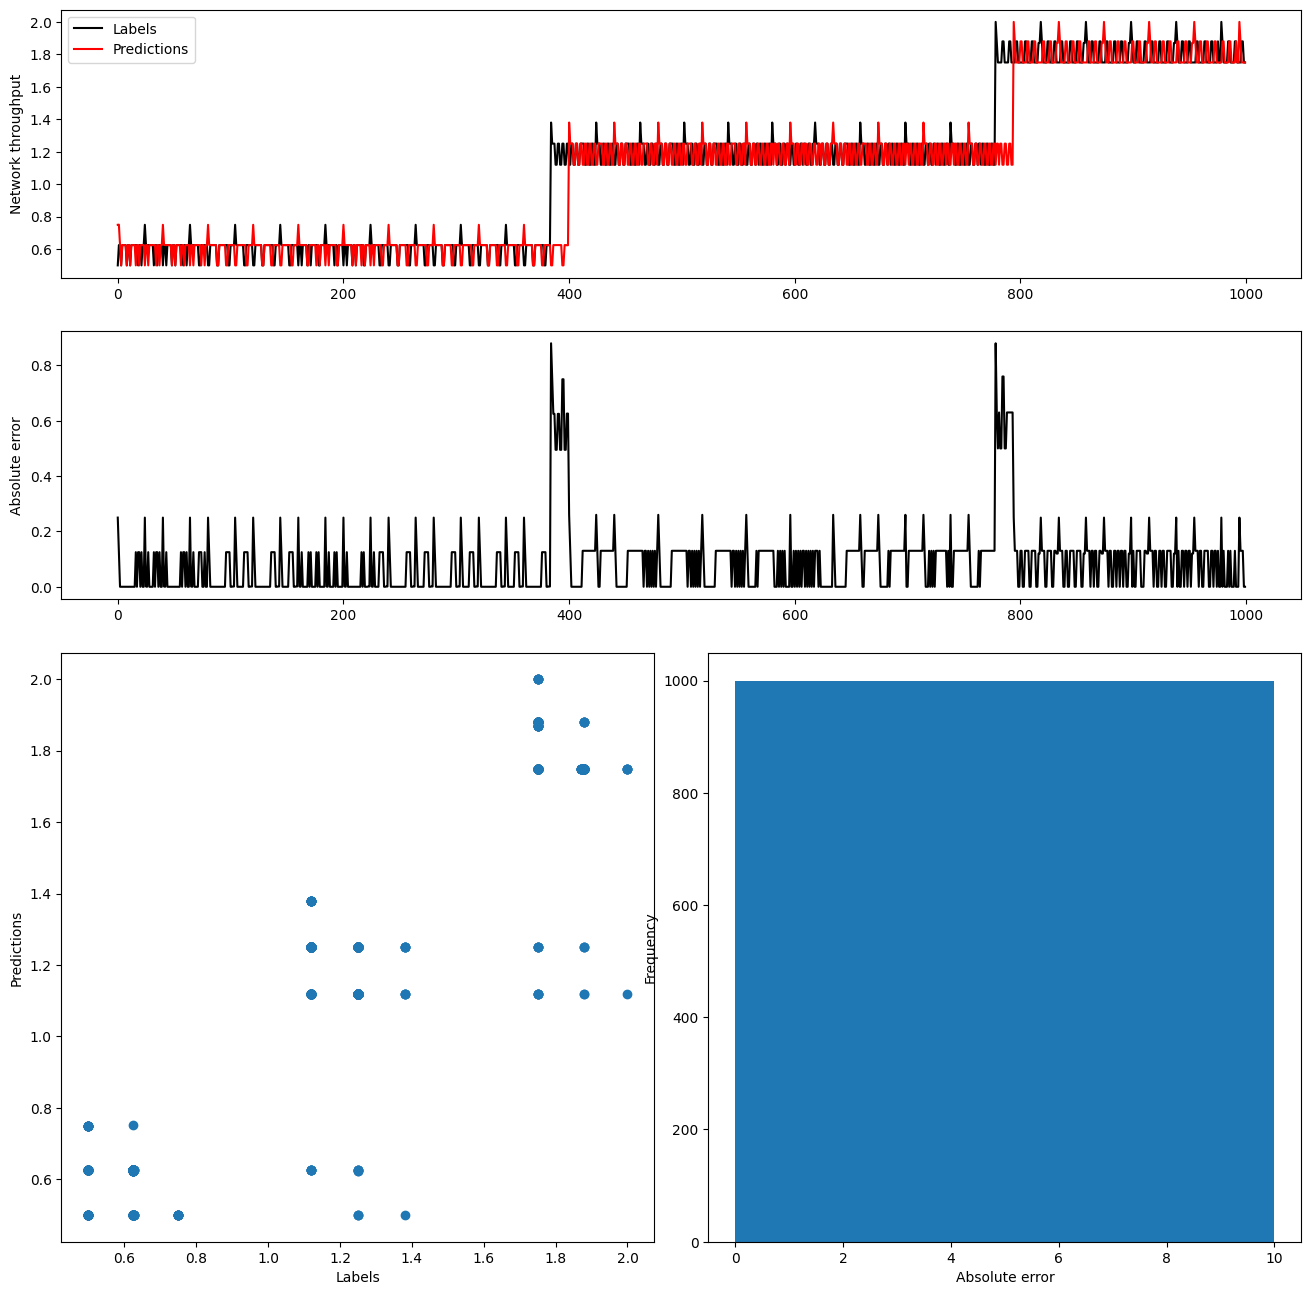

In [87]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)

  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])

  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Network throughput')
  ax1.legend()

  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")

  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)

  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualising the first 1000 predictions
PlotResults(r0_train[:1000],y0_train[:1000])

In [88]:
# checking
print(train_scaled.shape)
print(train_labels.shape)
print(val_scaled.shape)
print(val_labels.shape)

(1584, 3)
(1584,)
(392, 3)
(392,)


## Building models

In [89]:
# Stage 1 model: Model only using current features for prediction
# Starting from the scaled datasets extracted above: train_scaled and val_scaled
# First, converting the data into the right format for the LSTM network (as demonstrated before)

X_train_dense,r_train_dense = create_dataset_windowed(train_scaled,train_labels)
X_train_dense = np.squeeze(X_train_dense)
X_val_dense,r_val_dense = create_dataset_windowed(val_scaled,val_labels)
X_val_dense = np.squeeze(X_val_dense)

print(X_train_dense.shape)
print(r_train_dense.shape)
print(X_val_dense.shape)
print(r_val_dense.shape)

(1568, 3)
(1568,)
(376, 3)
(376,)


In [90]:
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [91]:
from keras.callbacks import LearningRateScheduler
def create_model(input_shape):

    # Initializing the Sequential model
    model = Sequential()

    # Adding layers to the model
    model.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    # Compiling the model
    model.compile(optimizer=Nadam(lr=0.00001), loss='mae')

    # Returning the model
    return model

In [92]:
LSTM_model = create_model((3,1))
LSTM_history = LSTM_model.fit(X_train_dense, r_train_dense, epochs=40, batch_size=64, validation_data=(X_val_dense, r_val_dense))

Epoch 1/40
25/25 [==============================] - 20s 102ms/step - loss: 92.6291 - val_loss: 71.6233
Epoch 2/40
25/25 [==============================] - 1s 20ms/step - loss: 55.1136 - val_loss: 42.1768
Epoch 3/40
25/25 [==============================] - 1s 20ms/step - loss: 33.6983 - val_loss: 28.5796
Epoch 4/40
25/25 [==============================] - 0s 19ms/step - loss: 23.7725 - val_loss: 21.3750
Epoch 5/40
25/25 [==============================] - 0s 19ms/step - loss: 17.7795 - val_loss: 16.4224
Epoch 6/40
25/25 [==============================] - 0s 19ms/step - loss: 13.5194 - val_loss: 12.9197
Epoch 7/40
25/25 [==============================] - 0s 19ms/step - loss: 10.4939 - val_loss: 10.4300
Epoch 8/40
25/25 [==============================] - 1s 23ms/step - loss: 8.2885 - val_loss: 8.5883
Epoch 9/40
25/25 [==============================] - 1s 25ms/step - loss: 6.8836 - val_loss: 7.3956
Epoch 10/40
25/25 [==============================] - 1s 24ms/step - loss: 5.7732 - val_loss: 

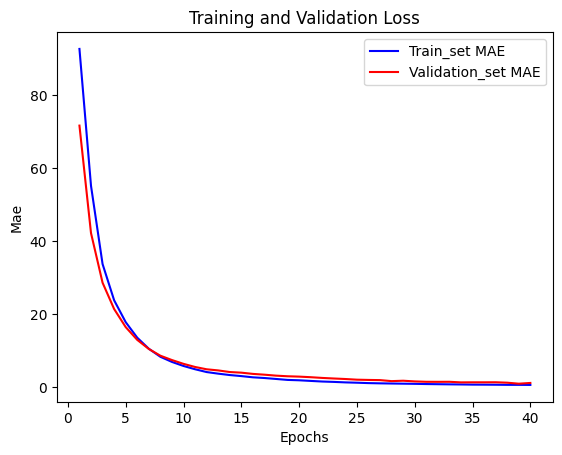

In [93]:
train_loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train_set MAE')
plt.plot(epochs, val_loss, 'r', label='Validation_set MAE')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

In [94]:
print(X_train_dense.shape)
print(X_val_dense.shape)

(1568, 3)
(376, 3)


12/12 [==============================] - 2s 5ms/step
"Current Network throuput" baseline:
 train mae =  0.25785547 
 validation mae =  0.78202635
(1568, 1)
(376, 1)


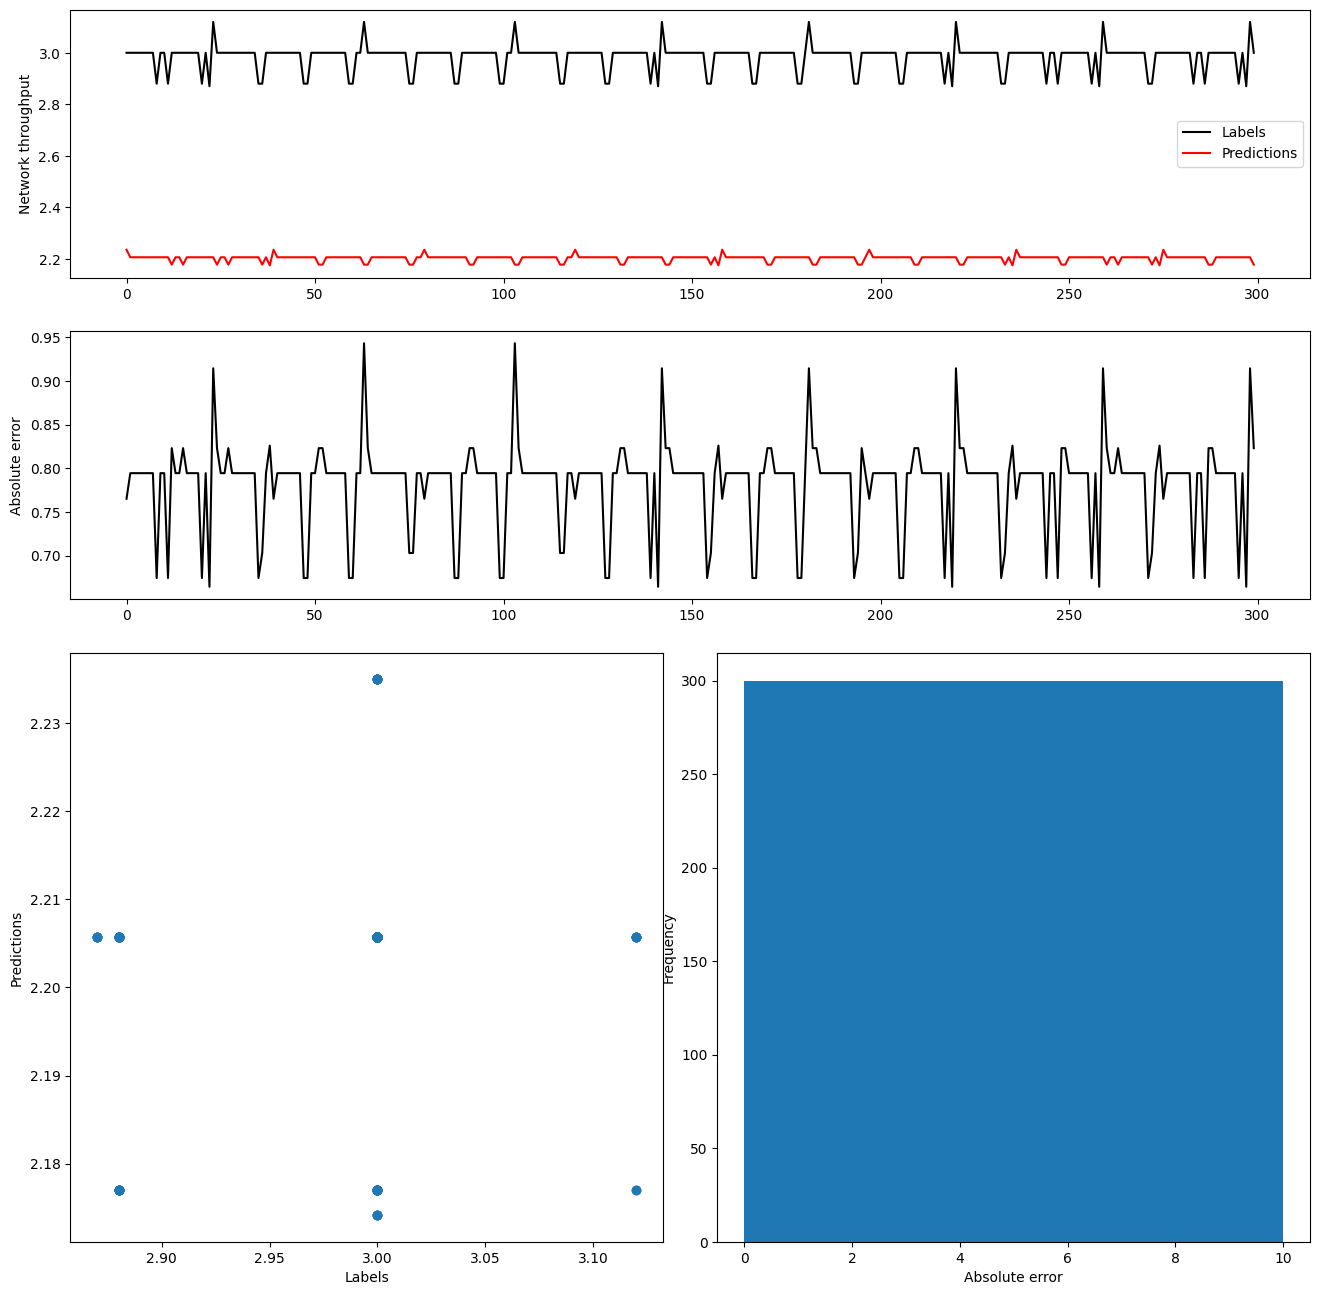

In [95]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_LSTM = LSTM_model.predict(X_train_dense)
y_val_LSTM = LSTM_model.predict(X_val_dense)

# Calculating the mean absolute error from the training and validation sets
mae_train_LSTM = mean_absolute_error(r_train_dense, y_train_LSTM)
mae_val_LSTM = mean_absolute_error(r_val_dense, y_val_LSTM)

# Printing the mean absolute error from the training and validation sets
print("\"Current Network throuput\" baseline:\n train mae = ", mae_train_LSTM,
      "\n validation mae = ", mae_val_LSTM)

# Printing the shapes of the predicted output from the training and validation sets
print(y_train_LSTM.shape)
print(y_val_LSTM.shape)

# Visualising first 300 predictions for validation
PlotResults(r_val_dense[:300], y_val_LSTM[:300, 0])

#Results on the test set

In [96]:
X_train_all_dense,r_train_all_dense = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=25)
X_train_all_dense = np.squeeze(X_train_all_dense)
X_test_dense,r_test_dense = create_dataset_windowed(test_scaled,test_labels, window_size=25)
X_test_dense = np.squeeze(X_test_dense)

print(X_train_all_dense.shape)
print(r_train_all_dense.shape)
print(X_test_dense.shape)
print(r_test_dense.shape)

(1960, 3)
(1960,)
(375, 3)
(375,)


In [97]:
class ElasticNetRegularizer(Regularizer):
    def __init__(self, l1=0.0, l2=0.0):
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x):
        return self.l1 * tf.reduce_sum(tf.abs(x)) + self.l2 * tf.reduce_sum(tf.square(x))

    def get_config(self):
        return {'l1': self.l1, 'l2': self.l2}

# Registering ElasticNetRegularizer with Keras
register_keras_serializable()(ElasticNetRegularizer)

__main__.ElasticNetRegularizer

In [98]:
from keras.callbacks import LearningRateScheduler
def create_model(input_shape):

    # Initializing the Sequential model
    model = Sequential()
    # Adding layers to the model
    model.add(Bidirectional(LSTM(512, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)),input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(256, return_sequences=True,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(128, return_sequences=False,
                                 kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=ElasticNetRegularizer(l1=0.001, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))

    # Compiling the model
    model.compile(optimizer=Nadam(lr=0.00001), loss='mae')

    # Returning the model
    return model

In [99]:
LSTM_model = create_model((3,1))
LSTM_model.summary()
LSTM_history = LSTM_model.fit(X_train_all_dense, r_train_all_dense, epochs=40, batch_size=64, validation_data=(X_test_dense, r_test_dense))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_27 (Bidirect  (None, 3, 1024)           2105344   
 ional)                                                          
                                                                 
 batch_normalization_36 (Ba  (None, 3, 1024)           4096      
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 3, 1024)           0         
                                                                 
 bidirectional_28 (Bidirect  (None, 3, 512)            2623488   
 ional)                                                          
                                                                 
 batch_normalization_37 (Ba  (None, 3, 512)            2048      
 tchNormalization)                                    

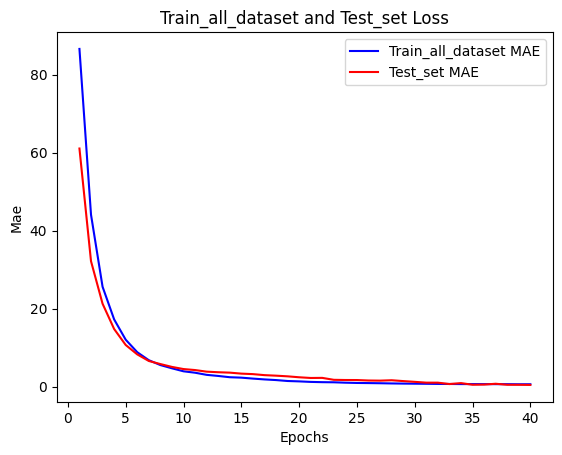

In [100]:
train_loss = LSTM_history.history['loss']
val_loss = LSTM_history.history['val_loss']

# Plotting the training and test loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Train_all_dataset MAE')
plt.plot(epochs, val_loss, 'r', label='Test_set MAE')
plt.title('Train_all_dataset and Test_set Loss')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend()
plt.show()

12/12 [==============================] - 0s 4ms/step
"Current Network throuput" baseline:
 train mae =  0.119394176 
 test mae =  0.107628874
(1960, 1)
(375, 1)


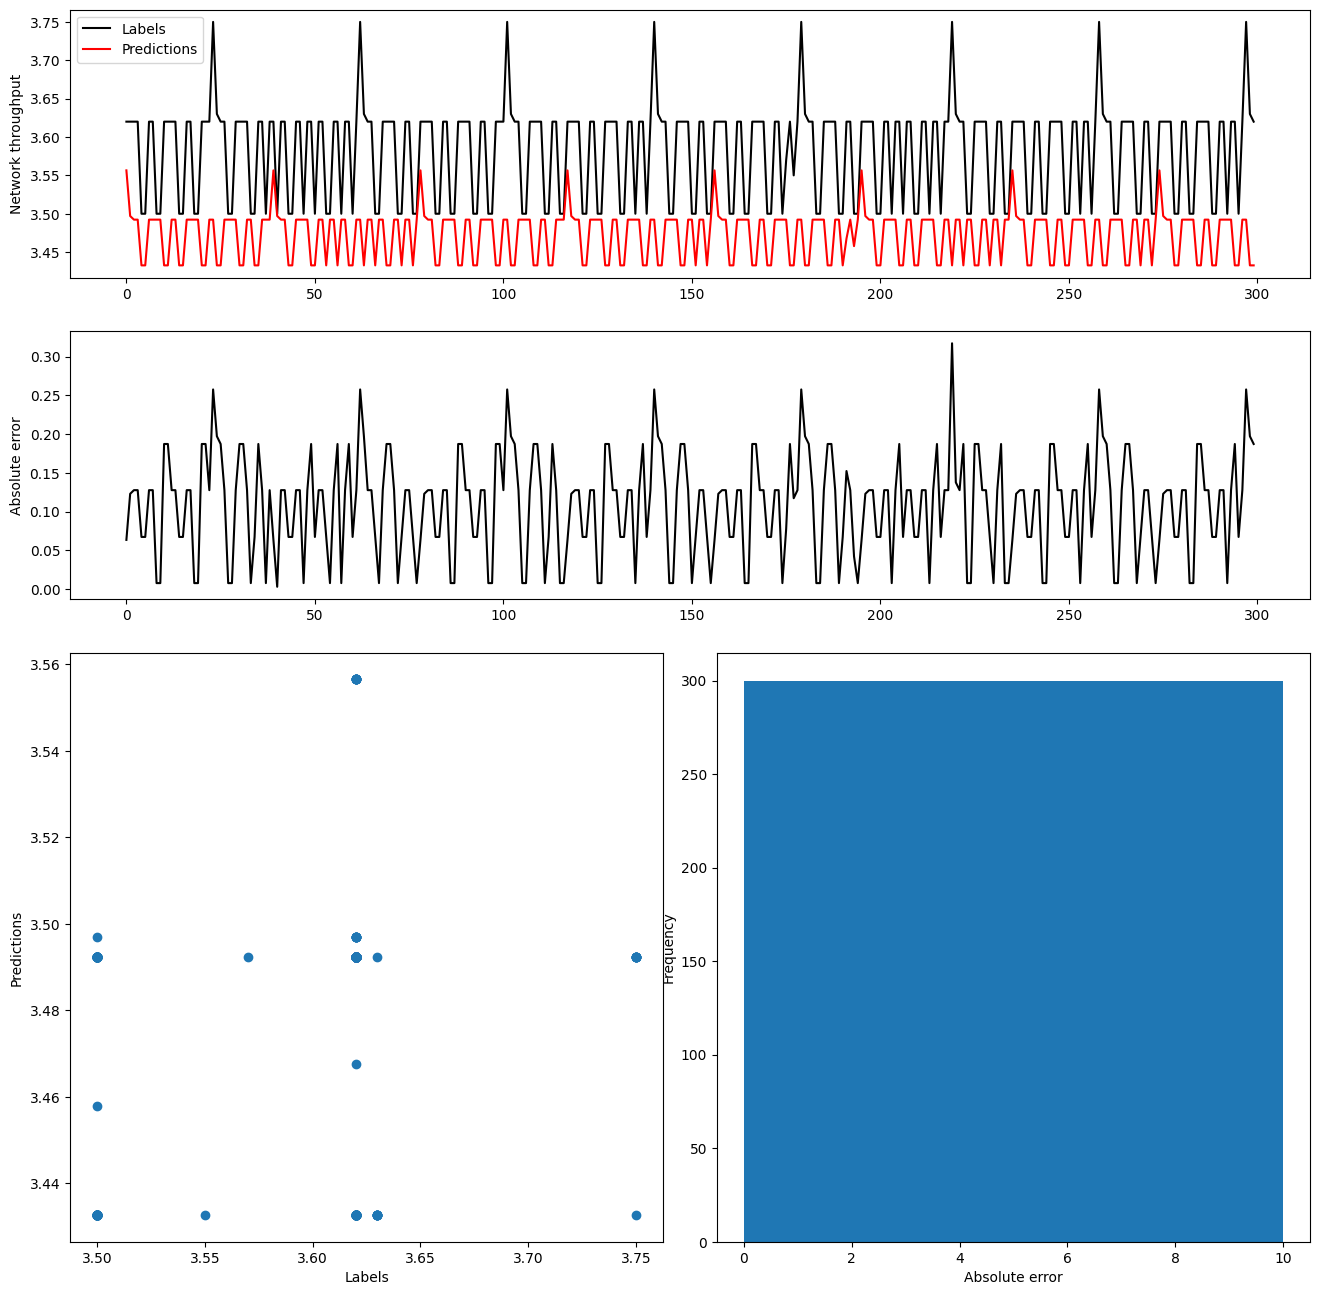

In [101]:
# Making predictions using the trained model
y_train_all_LSTM = LSTM_model.predict(X_train_all_dense)
y_test_LSTM = LSTM_model.predict(X_test_dense)

# Calculating the mean absolute error from the training and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_dense, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_dense, y_test_LSTM)

# Printing the mean absolute error from the training and test sets
print("\"Current Network throuput\" baseline:\n train mae = ", mae_train_all_LSTM,
      "\n test mae = ", mae_test_LSTM)

# Printing the shapes of the predicted output from the training and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

# Visualising first 300 predictions from the test set
PlotResults(r_test_dense[:300], y_test_LSTM[:300, 0])